# WorldBank Global Education Statistics (Data Exploration)

In this notebook we will start by loading the relevant datasets and exploring them. This will involve the steps of understanding the coding, cleaning the data with regard to our purposes and understanding the basic trends inside the data to define our questions and refine our hypothesis.

> As this notebook is focused on data exploration it can be a bit ugly at times. If you only want the clear analysis you can jump to the `2X_aly_NAME` notebooks.

More information on the dataset can be found on [kaggle](https://www.kaggle.com/theworldbank/education-statistics) and on the [EdStats Homepage](http://datatopics.worldbank.org/education/).

In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
%matplotlib inline

# some pandas options
pd.set_option('display.max_colwidth', -1)

datapath = "./datasets/edstats"
df_country = pd.read_csv(os.path.join(datapath, "EdStatsCountry.csv"))
df_data = pd.read_csv(os.path.join(datapath, "EdStatsData.csv"))
df_series = pd.read_csv(os.path.join(datapath, "EdStatsSeries.csv"))
df_note = pd.read_csv(os.path.join(datapath, "EdStatsFootNote.csv"))
df_cseries = pd.read_csv(os.path.join(datapath, "EdStatsCountry-Series.csv"))

In [392]:
df_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, male (%)",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The datasets are structured as follows:

* `df_country` contains a list of all participating countries (total of 241)
* `df_data` contains a combination of each country and each indicator (total of 3665 indicators) as well as measurment values for these indicators from 1970 to 2017 and projects from 2020 to 2100.
* `df_series` contains the list of all indicators, their category group and further additional information
* `df_cseries` contains general information about entire indicators that have been estimated for certain countries
* `df_note` contains informations about the uncertainty and origin of the data series used for the indicators for every single year (note that some years are missing, due to lack of data for the country in that year)

## Data Structure

Now that we know the general structure of the data, lets take a deeper look at the actual data quality of the dataset.

### Missing Values

We will first look at the actual amount of data we have available for each indicator and each country.

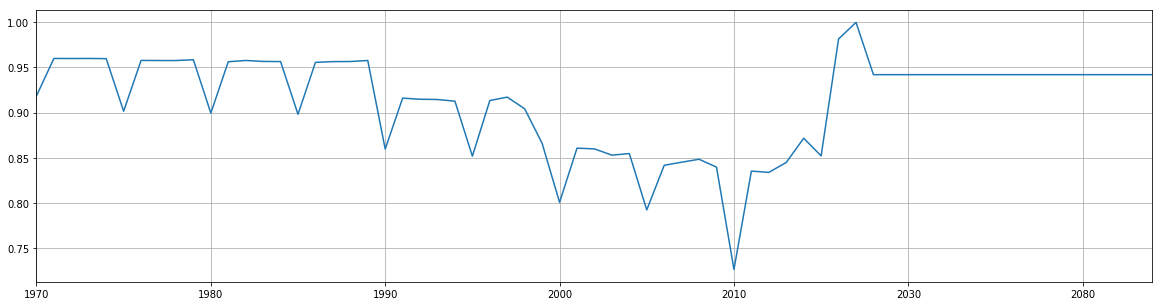

In [94]:
# select the indicator years
ind_years = df_data.iloc[:, 4:-1]
ind_years = ind_years.set_index(df_data.iloc[:, 3].values)

nan_years_perc = ind_years.isnull().apply(lambda col: col.mean())
nan_years_perc.plot(figsize=(20,5), grid=True);

This shows us that we have quite a lot of missing values for our indicators. Most of the data seems to be collected in periodic intervals (i.e. 5 years census). The amount of measured indicators has grown since the 2000s, with a peak at 2010.

Lets look at the data per country:

In [143]:
# match the year data with the country code
ind_years = df_data.iloc[:, 4:-1].isnull()
ind_years['Country'] = df_data.iloc[:, 1]

# group by country and extract the mean of missing values for each country
ind_country = ind_years.groupby('Country').mean()
ind_country_stats = ind_country.mean(axis=1).rename("perc_nan")

# match countries with geographical regions
ind_region = pd.merge(ind_country_stats.reset_index(), df_country, left_on="Country", right_on="Country Code")

In [154]:
#ind_region[['Region', "perc_nan"]].groupby('Region').mean().sort_values(by="perc_nan")
ind_region[['Region', "perc_nan"]].groupby('Region').describe()

perc_nan                                          \
                              count      mean       std       min       25%   
Region                                                                        
East Asia & Pacific            36.0  0.923123  0.042070  0.864410  0.887619   
Europe & Central Asia          57.0  0.902779  0.043028  0.856405  0.873011   
Latin America & Caribbean      41.0  0.911809  0.042666  0.862433  0.878283   
Middle East & North Africa     21.0  0.888810  0.025017  0.855506  0.871256   
North America                   3.0  0.917288  0.043916  0.882846  0.892562   
South Asia                      8.0  0.904345  0.013948  0.889046  0.894357   
Sub-Saharan Africa             48.0  0.899502  0.025550  0.862063  0.880962   

                                                          
                                 50%       75%       max  
Region                                                    
East Asia & Pacific         0.908647  0.965172  0.999349  
Europe & Central Asia       0.886166  0.908125  0.999131  
Latin America & Caribbean   0.895414  0.942046  0.999631  
Middle East & North Africa  0.877423  0.902391  0.938663  
North America               0.902277  0.934509  0.966742  
South Asia                  0.901828  0.909957  0.930477  
Sub-Saharan Africa          0.895359  0.910885  0.992432

In [151]:
#page = 80
#fig, axs = plt.subplots(int(ind_country_stats.shape[0] / page) + 1, 1)
#for i in range(0, ind_country_stats.shape[0], page):
#    ind_country_stats.iloc[i:i+80].plot.bar(figsize=(20,15), grid=True, ax=axs[int(i / page)]);
ind_region[['Table Name', 'Region', 'perc_nan']].sort_values(by='perc_nan')

,Table Name,Region,perc_nan
146,Malta,Middle East & North Africa,0.855506
49,Cyprus,Europe & Central Asia,0.856405
104,Italy,Europe & Central Asia,0.857358
19,Bulgaria,Europe & Central Asia,0.860657
95,Hungary,Europe & Central Asia,0.861282
135,Morocco,Middle East & North Africa,0.861799
160,Niger,Sub-Saharan Africa,0.862063
141,Mexico,Latin America & Caribbean,0.862433
42,Colombia,Latin America & Caribbean,0.863646
209,Syrian Arab Republic,Middle East & North Africa,0.864250


As we can see from the latter table, the amount of measurements is not directly linked to the geographical region, but rather only to the country itself. Nonetheless, the description table shows at that `Europe & Central Asia`, `Middle East & North Africa` and `South Asia` actually have quite dense data points for most countries (with dense in the context of this data meaning, they are around or above 10% values).

Lets look at the data for the single indicators:

In [176]:
# select the indicator data
# TODO: add perc of countries that have at least one value?
ind_indic = df_data.iloc[:, 4:-1].isnull().mean(axis=1).rename("perc_nan")
ind_indic = ind_indic.reset_index().set_index(df_data.iloc[:, 2:4].values).drop('index', axis=1)
ind_indic = ind_indic.reset_index().groupby('index').mean().sort_values(by="perc_nan")
print("Total Rows: {}".format(ind_indic.shape[0]))
ind_indic.head(50)
#ind_indic = ind_indic.groupby('Indicator Name')

Total Rows: 3665


,perc_nan
index,
"(Population, total, SP.POP.TOTL)",0.290846
"(Population growth (annual %), SP.POP.GROW)",0.291227
"(Population, ages 15-64 (% of total), SP.POP.1564.TO.ZS)",0.348824
"(Population, female (% of total), SP.POP.TOTL.FE.ZS)",0.349460
"(Population, ages 0-14 (% of total), SP.POP.0014.TO.ZS)",0.349460
"(Population, male (% of total), SP.POP.TOTL.MA.ZS)",0.349460
"(Population, ages 0-14, male, SP.POP.0014.MA.IN)",0.351430
"(Population, ages 0-14, total, SP.POP.0014.TO)",0.351430
"(Population, ages 15-64, female, SP.POP.1564.FE.IN)",0.351430


So this gives us an overview of the most densly populated indicators, that we might consider for our analysis.

### Matching Errors

There are some matching errors regarding country names between the `df_data` and `df_country` tables (same errors potentially arise in other tables as well):

In [33]:
c1 = df_data['Country Name'].value_counts()
c2 = df_country['Table Name'].value_counts()
ins = c1.index.intersection(c2.index)

print(c2.index.difference(ins))
print(c1.index.difference(ins))

Index(['Curaçao', 'Côte d'Ivoire', 'East Asia & Pacific (all income levels)',
       'Europe & Central Asia (all income levels)', 'Faeroe Islands',
       'Korea, Dem. Rep.', 'Latin America & Caribbean (all income levels)',
       'Middle East & North Africa (all income levels)',
       'Sub-Saharan Africa (all income levels)', 'São Tomé and Principe'],
      dtype='object')
Index(['British Virgin Islands', 'Cote d'Ivoire', 'Curacao',
       'East Asia & Pacific (excluding high income)',
       'Europe & Central Asia (excluding high income)', 'Faroe Islands',
       'Korea, Dem. People’s Rep.',
       'Latin America & Caribbean (excluding high income)',
       'Middle East & North Africa (excluding high income)',
       'Sao Tome and Principe', 'Sub-Saharan Africa (excluding high income)'],
      dtype='object')


The matching of the country codes shows that the `df_data` table actually contains entries about one country that is not listed in the country table (`df_country`), namely the [British Virgin Islands](https://en.wikipedia.org/wiki/British_Virgin_Islands). This shouldn't be too dramatic (their influence on global trends should be fairly limited).

In [172]:
c1 = df_data['Country Code'].value_counts()
c2 = df_country['Country Code'].value_counts()
ins = c1.index.intersection(c2.index)

print(c2.index.difference(ins))
print(c1.index.difference(ins))

Index([], dtype='object')
Index(['VGB'], dtype='object')


## Data Selection

Now that we have looked at the density (or more sparsity) of the data, we can go on and look at the actual data points we have in order to select the relevant indicators to answer our questions.

### Relevant List of countries

The first step we do, is to identify the relevant list of countries. One thing to be aware of, is the fact that the dataset contains already aggregated data records (e.g. `World` or `Arab World`)

In [327]:
df_aggs = df_country[df_country['Special Notes'].fillna('').str.contains('aggregate')]
df_aggs.head(5)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
5,ARB,Arab World,Arab World,Arab World,1A,NaN,Arab World aggregate. Arab World is composed of members of the League of Arab States.,NaN,NaN,1A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,EAP,East Asia & Pacific (developing only),East Asia & Pacific,East Asia & Pacific (developing only),4E,NaN,East Asia and Pacific regional aggregate (does not include high-income economies).,NaN,NaN,4E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,EAS,East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),Z4,NaN,East Asia and Pacific regional aggregate (including high-income economies).,NaN,NaN,Z4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,ECA,Europe & Central Asia (developing only),Europe & Central Asia,Europe & Central Asia (developing only),7E,NaN,Europe and Central Asia regional aggregate (does not include high-income economies).,NaN,NaN,7E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,ECS,Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Z7,NaN,Europe and Central Asia regional aggregate (including high-income economies).,NaN,NaN,Z7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that aggregations are made along multiple dimensions:

* Geographical Region
* Income
* Political Region (e.g. European Union)
* Economic Situations (e.g. Developing Nations or OECD Countries)

Lets create a list of the relevant country codes, so that we can filter them later on

In [291]:
ls_aggs = df_aggs['Country Code'].drop_duplicates().tolist()
#ls_aggs

### How does years of schooling relate to proficiency in skills

For this question we need:

* Years of primary / secondary / tertiary education in the specific country (theoretical and actual)
* % of population that has access to this kind of education (to correct for effects caused by uneducated population)
* Proficiency in various skills (including math, reading, etc)

In [328]:
# select list of all indicators
df_inds = df_data.iloc[:, 2:4].drop_duplicates()
df_inds.head()

,Indicator Name,Indicator Code
0,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2
1,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F
2,"Adjusted net enrolment rate, lower secondary, gender parity index (GPI)",UIS.NERA.2.GPI
3,"Adjusted net enrolment rate, lower secondary, male (%)",UIS.NERA.2.M
4,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR


In [188]:
# search for education durations
df_inds[df_inds['Indicator Name'].str.contains('duration of .* education', regex=True)]

,Indicator Name,Indicator Code
2982,Theoretical duration of lower secondary education (years),SE.SEC.DURS.LO
2983,Theoretical duration of post-secondary non-tertiary education (years),UIS.THDUR.4.A.GPV
2984,Theoretical duration of pre-primary education (years),UIS.THDUR.0
2985,Theoretical duration of primary education (years),SE.PRM.DURS
2986,Theoretical duration of secondary education (years),SE.SEC.DURS
2987,Theoretical duration of upper secondary education (years),SE.SEC.DURS.UP


In [189]:
# search for population applicable to education
df_inds[df_inds['Indicator Name'].str.contains('Population of the official age .* education', regex=True)]
# this can in turn be combined with total education

,Indicator Name,Indicator Code
2311,"Population of the official age for lower secondary education, both sexes (number)",SP.SEC.LTOT.IN
2312,"Population of the official age for lower secondary education, female (number)",SP.SEC.LTOT.FE.IN
2313,"Population of the official age for lower secondary education, male (number)",SP.SEC.LTOT.MA.IN
2314,"Population of the official age for post-secondary non-tertiary education, both sexes (number)",UIS.SAP.4
2315,"Population of the official age for post-secondary non-tertiary education, female (number)",UIS.SAP.4.F
2316,"Population of the official age for post-secondary non-tertiary education, male (number)",UIS.SAP.4.M
2317,"Population of the official age for pre-primary education, both sexes (number)",SP.PRE.TOTL.IN
2318,"Population of the official age for pre-primary education, female (number)",SP.PRE.TOTL.FE.IN
2319,"Population of the official age for pre-primary education, male (number)",SP.PRE.TOTL.MA.IN
2320,"Population of the official age for primary education, both sexes (number)",SP.PRM.TOTL.IN


In [459]:
# search for population applicable to education
df_inds[df_inds['Indicator Name'].str.contains('Wittgenstein Projection: Population .* education', regex=True)]

,Indicator Name,Indicator Code
3585,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Incomplete Primary. Female,PRJ.POP.1519.S1.FE
3586,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Incomplete Primary. Male,PRJ.POP.1519.S1.MA
3587,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Incomplete Primary. Total,PRJ.POP.1519.S1.MF
3588,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Lower Secondary. Female,PRJ.POP.1519.2.FE
3589,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Lower Secondary. Male,PRJ.POP.1519.2.MA
3590,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Lower Secondary. Total,PRJ.POP.1519.2.MF
3591,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. No Education. Female,PRJ.POP.1519.NED.FE
3592,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. No Education. Male,PRJ.POP.1519.NED.MA
3593,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. No Education. Total,PRJ.POP.1519.NED.MF
3594,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Post Secondary. Female,PRJ.POP.1519.4.FE


As we can see from the analysis the `Theoretical Duration` columns should give us a general idea of how the age structure of education looks like in a certain country. The `Population of official age` indicators show us what portion of the population is actually applicable to education (which we can convert to total number using the `Total Population` indicator). Finally the `Wittgenstein Projects` (more information [here](https://datacatalog.worldbank.org/wittgenstein-projection-percentage-population-age-15-19-highest-level-educational-attainment-upper-0)) show us the actual education certain parts of the education received. Those are also divided in different age groups, so we can match them against the .

In [322]:
# list of total wittgenstein projection indicators
witt_total = ['PRJ.POP.ALL.S1.MF', 'PRJ.POP.ALL.1.MF', 'PRJ.POP.ALL.2.MF', 'PRJ.POP.ALL.3.MF', 'PRJ.POP.ALL.4.MF', 'PRJ.POP.ALL.NED.MF']

# select the indicators from the list
df_witt = df_data[df_data['Indicator Code'].isin(witt_total)]

# filter the data that is 
df_witt_clean = df_witt[df_witt['Country Code'].isin(ls_aggs) == False]
df_witt_world = df_witt[df_witt['Country Code'] == 'WLD']

# normalize by total population in the country (TODO: interpolate values for missing data)
#df_witt.groupby('Indicator Name').sum().transpose().plot()
df_witt_sum = df_witt_clean.groupby('Indicator Name').sum().transpose()
df_witt_sum = df_witt_sum[df_witt_sum.sum(axis=1) > 0]

# do the same for the world data and compare
df_witt_sum_wld = df_witt_world.groupby('Indicator Name').sum().transpose()
df_witt_sum_wld = df_witt_sum_wld[df_witt_sum_wld.sum(axis=1) > 0]

# if we compare the world data with the aggregated local data, we see that the world data is larger - assuming that it has more information, we will continue by using the world data
#((df_witt_sum_wld - df_witt_sum) * 1000).sum(axis=1)
#df_witt_sum_wld - df_witt_sum

df_witt_sum

Indicator Name,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Incomplete Primary. Total,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Lower Secondary. Total,Wittgenstein Projection: Population in thousands by highest level of educational attainment. No Education. Total,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Primary. Total,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total
2010,307193.46,1110203.07,763362.45,604617.48,879073.63,1244554.96
2015,305121.13,1186600.28,738463.07,712885.38,907702.59,1402897.24
2020,300354.43,1255739.18,706207.08,826250.98,932231.59,1565619.21
2025,292105.88,1318794.25,670979.17,945941.57,947978.61,1741492.63
2030,281433.03,1361656.10,631408.26,1075102.38,956488.50,1919356.94
2035,267549.78,1389055.24,588554.37,1211046.97,958010.80,2095296.55
2040,250719.02,1396696.32,542920.47,1352344.43,951585.71,2265508.94
2045,231627.62,1385719.13,495204.07,1497035.67,937760.92,2426604.59
2050,210965.52,1359077.79,446393.48,1643808.59,917527.51,2579028.45
2055,189391.16,1317089.78,397135.46,1792239.05,891118.40,2721298.79


The aggregated world data seems to contain a wider usage of the indicator (accounting for roughly 120 Mil. people more). However, we cannot source the influences back to individual countries (which we need to to cross reference it with other indicators and answer our questions). We will therefore continue to use the data from separate countries.

In [323]:
cols = [(c, "Population (in 1000) with {}".format(c[93:-7])) for c in df_witt_sum.columns.values]
#len('Wittgenstein Projection: Population in thousands by highest level of educational attainment. ')
df_witt_sum = df_witt_sum.rename(columns=dict(cols))

In [324]:
#df_witt_sum.style.background_gradient(cmap='viridis', low=.5, high=0)
df_witt_sum.iloc[:2, :].style\
    .bar(align='mid', color=['#d65f5f', '#5fba7d'])

Indicator Name,Population (in 1000) with Incomplete Primary,Population (in 1000) with Lower Secondary,Population (in 1000) with No Education,Population (in 1000) with Post Secondary,Population (in 1000) with Primary,Population (in 1000) with Upper Secondary
2010,307193,1.1102e+06,763362,604617,879074,1.24455e+06
2015,305121,1.1866e+06,738463,712885,907703,1.4029e+06


In [325]:
(df_witt_sum.iloc[1, :] - df_witt_sum.iloc[0, :]).rename("2010 to 2015").to_frame().style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,2010 to 2015
Indicator Name,
Population (in 1000) with Incomplete Primary,-2072.33
Population (in 1000) with Lower Secondary,76397.2
Population (in 1000) with No Education,-24899.4
Population (in 1000) with Post Secondary,108268
Population (in 1000) with Primary,28629
Population (in 1000) with Upper Secondary,158342


In [326]:
# check if the same number of countries is available for both years (2010 and 15)
df_witt_notnull = df_witt_clean[df_witt_clean.iloc[:, 4:-1].isnull().min(axis=1) == False]
df_witt_notnull.groupby('Indicator Name').count()[['2010', '2015']]

,2010,2015
Indicator Name,,
Wittgenstein Projection: Population in thousands by highest level of educational attainment. Incomplete Primary. Total,166,166
Wittgenstein Projection: Population in thousands by highest level of educational attainment. Lower Secondary. Total,166,166
Wittgenstein Projection: Population in thousands by highest level of educational attainment. No Education. Total,166,166
Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total,166,166
Wittgenstein Projection: Population in thousands by highest level of educational attainment. Primary. Total,166,166
Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total,166,166


By looking at the values from the wittgenstein projections in detail, we see that they are only available for the years 2010 and 2015 as actual data (the remaining years are estimates). What we can learn from these values is, that the number of people with no or incomplete education is decreasing only minimaly. However the number of persons reaching higher educations (esp. in `Upper Secondary` and `Post Secondary`) is inceasing significantly. However, coming from only 166 countries, this data is quite sparse. Let's see where the data originates to be aware of potential regional biases from the dataset:

In [355]:
# select the total number of indiviuals counted for each year to 
sr_ppl_counted = df_witt_sum.sum(axis=1)

# append region
df_witt_region = pd.merge(df_witt_notnull, df_country[['Country Code', 'Region', ]], on='Country Code')

# looking at the region distribution
df_region  = df_witt_region.groupby('Region').sum()[['2010', '2015']]
(df_region / df_region.sum(axis=0)).style.background_gradient(cmap='Greens')

,2010,2015
Region,,
East Asia & Pacific,0.34476,0.338082
Europe & Central Asia,0.145653,0.137968
Latin America & Caribbean,0.0863627,0.0872936
Middle East & North Africa,0.0499753,0.0517721
North America,0.0563249,0.0550648
South Asia,0.220866,0.226982
Sub-Saharan Africa,0.096058,0.102837


In [378]:
# looking at the top individual countries
df_region  = df_witt_region.groupby(['Country Name', 'Region']).sum()[['2010', '2015']]
(df_region / df_region.sum(axis=0)).sort_values(by="2010", ascending=False).head(10).style.background_gradient(cmap='Greens')

,,2010,2015
Country Name,Region,,
China,East Asia & Pacific,0.220081,0.214453
India,South Asia,0.173157,0.177178
United States,North America,0.0505332,0.0493494
Indonesia,East Asia & Pacific,0.0356523,0.0356485
Brazil,Latin America & Caribbean,0.029605,0.0297447
Russian Federation,Europe & Central Asia,0.0247418,0.022665
Pakistan,South Asia,0.0228549,0.0240982
Japan,East Asia & Pacific,0.022333,0.0208932
Bangladesh,South Asia,0.0208084,0.021363


In [358]:
# calculate the match of indicate region and normalize number of people per indicator
df_ind_region = df_witt_region.groupby(['Indicator Name', 'Region']).sum()[['2010', '2015']]
df_ind_total  = df_witt_region.groupby(['Indicator Name']).sum()[['2010', '2015']]
(df_ind_region / df_ind_total).style.background_gradient(cmap='Greens')

What we can see from the data is that most people recorded by this indicators are coming from the `East Asia` region. By looking at the countries, we can see that `China`, `US` and `India` are the largest contributors to this data. We should therefore consider to normalize the dataset according to the population in the individual countries (which is, what we will do next).

We can also see from grouped data that `South Asia` (i.e. `India`) appears to have a strong shift towards no education, while `East Asia` (`China`) has a focus toward primary or lower secondary education. Notable `East Asia` has also a large number of people in the Post Secondary education (leading to the assumption of a large rift in society between poorly educated and high educated groups - however, as the data is normalized according to the groups, we can not draw total conclussions)

In [444]:
# select the relevant population data
pop_ind = "SP.POP.TOTL"
#pop_ind = "SP.PRM.TOTL.IN"
df_pop = df_data[df_data['Indicator Code'] == pop_ind]
# eliminate total NaN data
df_pop = df_pop[df_pop.iloc[:, 4:-1].isnull().min(axis=1) == False]

# fill potential NaN data with linear regression
df_pop_data = df_pop.iloc[:, 4:50]
df_pop_data.interpolate(axis=1, inplace=True, limit_direction='both')

# compose final dataset
df_pop_data['Country Code'] = df_pop['Country Code']
df_pop = df_pop_data

df_pop.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Country Code
2533,1.234009e+08,1.267261e+08,1.300956e+08,1.335924e+08,1.373274e+08,1.413761e+08,1.457685e+08,1.504742e+08,1.554227e+08,1.605088e+08,...,3.246935e+08,3.324249e+08,3.401490e+08,3.477370e+08,3.551370e+08,3.624666e+08,3.697615e+08,3.697615e+08,3.697615e+08,ARB
6198,1.288581e+09,1.322182e+09,1.354003e+09,1.384272e+09,1.414385e+09,1.441542e+09,1.465815e+09,1.488757e+09,1.511580e+09,1.534796e+09,...,2.160432e+09,2.175832e+09,2.190811e+09,2.205615e+09,2.220358e+09,2.235430e+09,2.250552e+09,2.265898e+09,2.281203e+09,EAS
9863,1.115427e+09,1.146090e+09,1.175063e+09,1.203125e+09,1.229693e+09,1.253833e+09,1.276113e+09,1.296790e+09,1.317415e+09,1.338310e+09,...,1.922658e+09,1.936775e+09,1.950768e+09,1.964692e+09,1.978728e+09,1.993009e+09,2.007435e+09,2.022021e+09,2.036553e+09,EAP
13528,2.874162e+08,2.890325e+08,2.910407e+08,2.929618e+08,2.946894e+08,2.962447e+08,2.975730e+08,2.987386e+08,2.999089e+08,3.011000e+08,...,3.326452e+08,3.342747e+08,3.353609e+08,3.361515e+08,3.354258e+08,3.361673e+08,3.372969e+08,3.384296e+08,3.395192e+08,EMU
17193,7.379482e+08,7.436074e+08,7.498159e+08,7.558680e+08,7.617013e+08,7.673326e+08,7.728383e+08,7.780948e+08,7.832990e+08,7.885252e+08,...,8.784660e+08,8.819658e+08,8.855917e+08,8.890162e+08,8.910950e+08,8.946667e+08,8.988551e+08,9.030947e+08,9.074248e+08,ECS


In [448]:
df_witt_norm = df_witt_clean.set_index(df_witt_clean['Country Code'])
df_pop_norm = df_pop.set_index(df_pop['Country Code']).iloc[:, :-1] / 1000

df_witt_norm = df_witt_norm.combine(df_pop_norm, lambda s1, s2: s1/s2, overwrite=False)[['2010', '2015', 'Indicator Code', 'Indicator Name', 'Country Name']]

# filter empty
df_witt_norm = df_witt_norm[df_witt_norm.sum(axis=1) > 0]

# display data
df_witt_norm.groupby('Country Name').sum().describe()

,2010,2015
count,166.000000,166.000000
mean,0.716060,0.725422
std,0.122085,0.128053
min,0.426313,0.410329
25%,0.611294,0.616904
50%,0.714381,0.724836
75%,0.820093,0.827283
max,1.113815,1.150354


In [463]:
df_series[df_series['Indicator Name'].str.contains('Barro-Lee', case=False, regex=True)]['Indicator Name'].tolist()


['Barro-Lee: Percentage of female population age 15-19 with no education',
 'Barro-Lee: Percentage of population age 15-19 with no education',
 'Barro-Lee: Percentage of female population age 15+ with no education',
 'Barro-Lee: Percentage of population age 15+ with no education',
 'Barro-Lee: Percentage of female population age 20-24 with no education',
 'Barro-Lee: Percentage of population age 20-24 with no education',
 'Barro-Lee: Percentage of female population age 25-29 with no education',
 'Barro-Lee: Percentage of population age 25-29 with no education',
 'Barro-Lee: Percentage of female population age 25+ with no education',
 'Barro-Lee: Percentage of population age 25+ with no education',
 'Barro-Lee: Percentage of female population age 30-34 with no education',
 'Barro-Lee: Percentage of population age 30-34 with no education',
 'Barro-Lee: Percentage of female population age 35-39 with no education',
 'Barro-Lee: Percentage of population age 35-39 with no education',
 'Barro

We can now normalize the indicators by the strength of the population. However the indicator show that the sum of people tracked by wittgenstein does not match up with the total population of the country. The description of the dataset shows that the data does not match up, with maximum values being over the .

---

Next, we will check which indicators are available for measuring the proficieny in specific skills:

In [197]:
# search for population applicable to education
df_inds[df_inds['Indicator Name'].str.contains('achievement|benchmark|proficiency', regex=True)]

,Indicator Name,Indicator Code
1391,LLECE: 3rd grade students by mathematics proficiency level (%). Below Level 1,LO.LLECE.MAT3.0
1392,LLECE: 3rd grade students by mathematics proficiency level (%). Level 1,LO.LLECE.MAT3.1
1393,LLECE: 3rd grade students by mathematics proficiency level (%). Level 2,LO.LLECE.MAT3.2
1394,LLECE: 3rd grade students by mathematics proficiency level (%). Level 3,LO.LLECE.MAT3.3
1395,LLECE: 3rd grade students by mathematics proficiency level (%). Level 4,LO.LLECE.MAT3.4
1396,LLECE: 3rd grade students by reading proficiency level (%). Below Level 1,LO.LLECE.REA3.0
1397,LLECE: 3rd grade students by reading proficiency level (%). Level 1,LO.LLECE.REA3.1
1398,LLECE: 3rd grade students by reading proficiency level (%). Level 2,LO.LLECE.REA3.2
1399,LLECE: 3rd grade students by reading proficiency level (%). Level 3,LO.LLECE.REA3.3
1400,LLECE: 3rd grade students by reading proficiency level (%). Level 4,LO.LLECE.REA3.4


From this analysis we actually see that there are many indicators regarding proficiency in science, math and reading. Also these indicators are much more fine-granular compared to the previous indicators. This means we either have to combine them for the regarding form of education (e.g. primary, secondary, etc) or to interpolate the fine-granular values for the population indicators.

## Conclusion

Main takeaways for further data analysis are:

* Indicators for 
* Some indicators have to be normalized using the population
* Sum of population and education metrics do not add up.